In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
#from scipy.stats import pearsonr

DATA PREPARATION

In [371]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code")
df=data_df.loc[38:97,["year", "coal_gen", "gas_gen", "price_gas", "price_brent","open_interest_gas","ets"]] 
print(df)

#first ets value at line 38

              year  coal_gen  gas_gen   price_gas  price_brent  \
38  Quarter 3 2007   25.6247  36.5543   51.080432    95.042017   
39  Quarter 4 2007   42.2876  39.5451   62.164090   111.593341   
40  Quarter 1 2008   33.4249  47.6124   68.556213   118.698225   
41  Quarter 2 2008   26.2931  41.9255   85.133566   162.404181   
42  Quarter 3 2008   22.0066  43.2801   97.887486   112.709529   
43  Quarter 4 2008   36.3285  40.1696   67.121560    52.282110   
44  Quarter 1 2009   37.8068  37.2688   36.747126    56.586207   
45  Quarter 2 2009   19.1026  38.1096   29.601367    78.929385   
46  Quarter 3 2009   15.5716  42.0710   36.757370    78.310658   
47  Quarter 4 2009   25.3169  46.0059   38.058691    87.957111   
48  Quarter 1 2010   30.9666  47.3291   33.344557    92.817059   
49  Quarter 2 2010   18.5478  44.6790   50.544444    83.344444   
50  Quarter 3 2010   18.8051  40.1098   52.403101    91.151717   
51  Quarter 4 2010   33.8568  40.3353   67.036224   104.006586   
52  Quarte

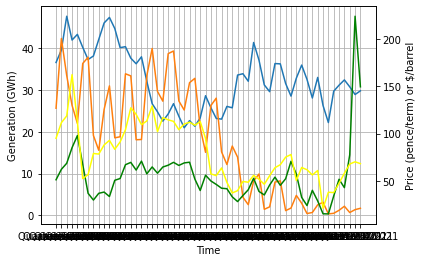

In [372]:
plt.plot(df.year, df.gas_gen)
plt.plot(df.year, df.coal_gen)
plt.xlabel("Time")
plt.ylabel("Generation (GWh)")
plt.grid()
plt2=plt.twinx()
plt2.plot(df.year, df.price_gas, color="green")
plt2.plot(df.year, df.price_brent, color="yellow")
plt2.set_ylabel("Price (pence/term) or $/barrel", color="black")
#plt.ylabel
plt.show()

In [374]:
#Vector:
dcoal=df.coal_gen
dgas=df.gas_gen
dprice_gas=df.price_gas
dprice_brent=df.price_brent
dOI=df.open_interest_gas
dETS=df.ets

DataSeries=[dgas,dprice_gas, dprice_brent,dOI,dETS]
#DataSeries=[dcoal,dgas,dprice_gas]


In [383]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
coal_gen,-0.192597,0.939398,11.000000
gas_gen,-2.007914,0.283114,2.000000
price_gas,-3.453892,0.009253,4.000000
price_brent,-2.228530,0.196054,0.000000
open_interest_gas,-1.716164,0.422804,6.000000
ets,2.869431,1.000000,6.000000


In [384]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
coal_gen,1.073109,0.010000,4.000000
gas_gen,0.431070,0.063763,4.000000
price_gas,0.103736,0.100000,3.000000
price_brent,0.761952,0.010000,4.000000
open_interest_gas,1.111221,0.010000,4.000000
ets,0.999275,0.010000,4.000000


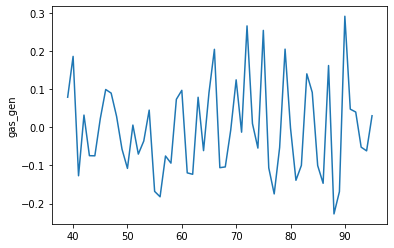

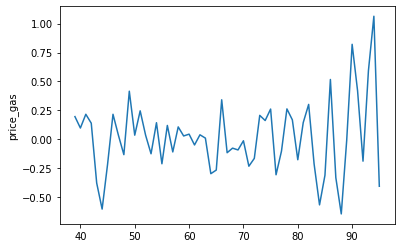

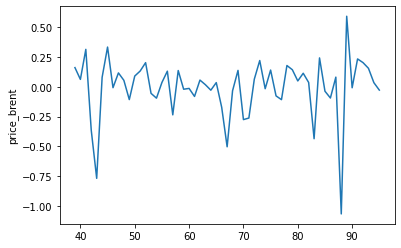

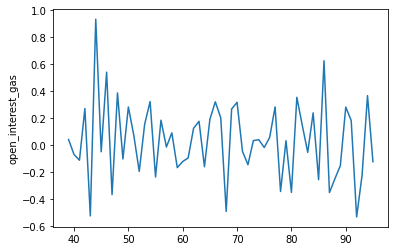

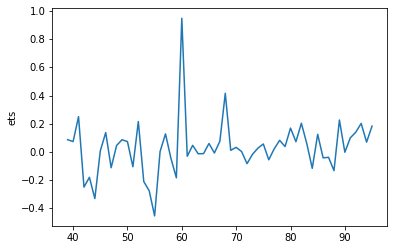

     gas_gen  price_gas  price_brent  open_interest_gas       ets
39  0.078643   0.196376     0.160542           0.040577  0.086051
40  0.185651   0.097877     0.061723          -0.070151  0.072697
41 -0.127199   0.216567     0.313504          -0.112760  0.249788
42  0.031799   0.139597    -0.365274           0.270830 -0.250737
43 -0.074582  -0.377313    -0.768160          -0.526321 -0.181208
44 -0.074954  -0.602445     0.079111           0.933494 -0.332161
45  0.022310  -0.216239     0.332788          -0.050160  0.005541
46  0.098892   0.216518    -0.007870           0.540765  0.136991
47  0.089411   0.034791     0.116166          -0.368244 -0.113069
48  0.028356  -0.132235     0.053781           0.386488  0.044873
49 -0.057622   0.415958    -0.107648          -0.103982  0.085883
50 -0.107883   0.036113     0.089543           0.282203  0.072752
51  0.005606   0.246267     0.131929           0.072494 -0.106357
52 -0.070462   0.035797     0.202002          -0.195852  0.215288
53 -0.0362

In [378]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

DataSeriesCorr=[]
for df in DataSeries:
    df_log = pd.Series(np.log(df))
    df_diff = df_log.diff().dropna()
    plt.plot(df_diff)
    plt.ylabel(df.name)
    plt.show()
    DataSeriesCorr.append(df_diff)

DataSeries = DataSeriesCorr

df_corr = pd.concat(DataSeriesCorr,axis=1)
print(df_corr)

In [385]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
gas_gen,-7.600567,0.000000,1.000000
price_gas,-5.116622,0.000013,5.000000
price_brent,-8.525599,0.000000,0.000000
open_interest_gas,-6.362847,0.000000,2.000000
ets,-7.268286,0.000000,0.000000


In [386]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
gas_gen,0.092142,0.100000,12.000000
price_gas,0.139550,0.100000,6.000000
price_brent,0.068400,0.100000,5.000000
open_interest_gas,0.250526,0.100000,5.000000
ets,0.248831,0.100000,1.000000


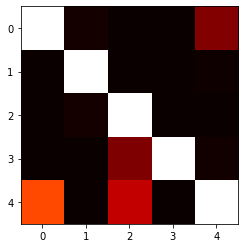

,gas_gen_x,price_gas_x,price_brent_x,open_interest_gas_x,ets_x
gas_gen_y,1.0000,0.0187,0.0034,0.0000,0.1815
price_gas_y,0.0000,1.0000,0.0017,0.0007,0.0115
price_brent_y,0.0000,0.0179,1.0000,0.0000,0.0019
open_interest_gas_y,0.0000,0.0014,0.1749,1.0000,0.0118
ets_y,0.4756,0.0000,0.2759,0.0001,1.0000


In [389]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    plt.imshow(df, cmap='hot', interpolation='nearest')
    plt.show()
    return df


##### actual test
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


In [ ]:
def plot_gen(series):
    plt.figure(figsize=(12,6))
    plt.plot(series, color='red')
    plt.grid()
    plt.ylabel('Generation output (GWh)', fontsize=16)

def plot_price(series):
    plt.figure(figsize=(12,6))
    plt.plot(series, color='green')
    plt.grid()
    plt.ylabel('Price p/term', fontsize=16)

def plot_basic(series, name):
    plt.figure(figsize=(9,4))
    plt.plot(series)
    plt.ylabel(name, fontsize=10)
    plt.grid()


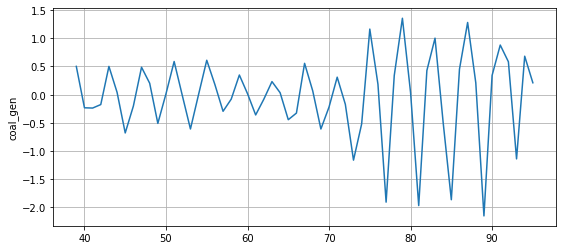

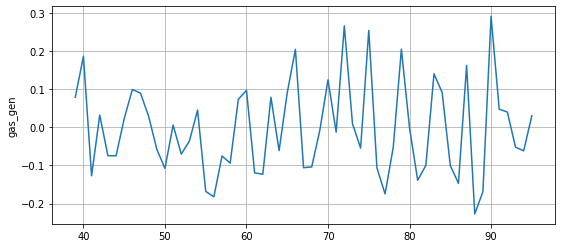

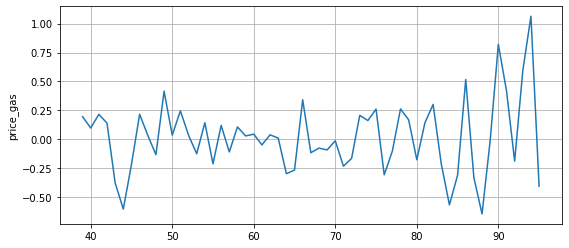

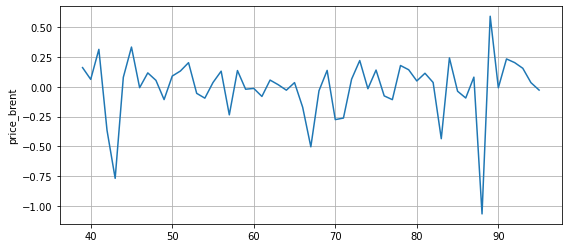

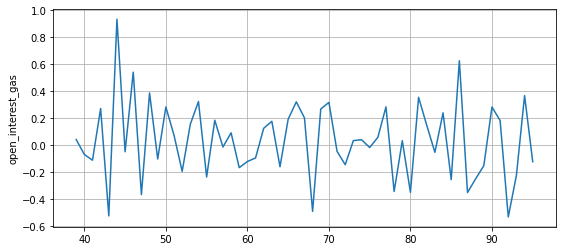

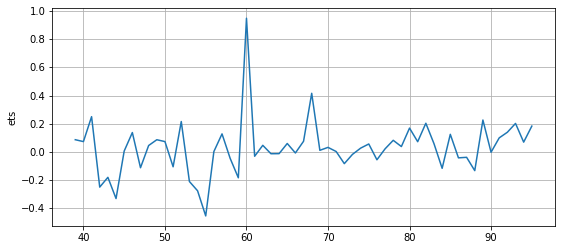

In [ ]:
for df in DataSeries:
#    avg, dev = df.mean(), df.std()
#    df = (df - avg)/dev
    plot_basic(df, df.name)



Remove seasonality: (quaterly or monthly)

Remove volatility: (lower timeframes)

Remove heteroscedadicity:

/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


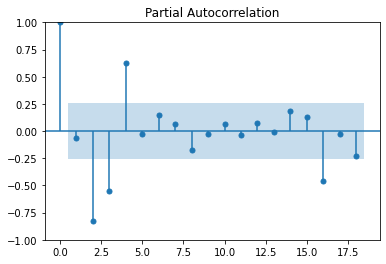

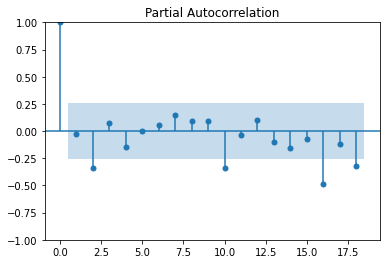

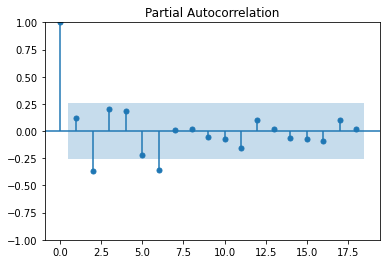

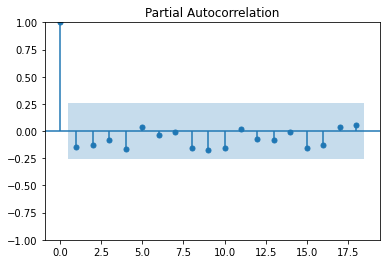

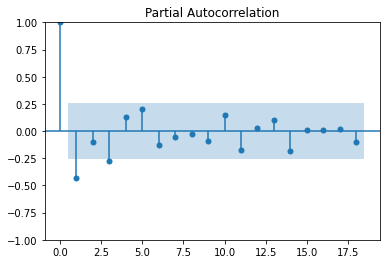

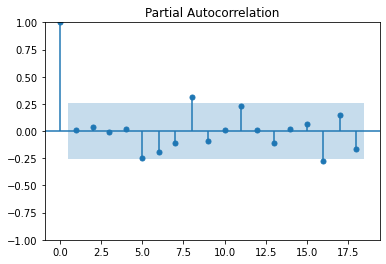

In [ ]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()



# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()




In [390]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order(maxlags=7)
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-15.55,-15.36*,1.761e-07*,-15.48*
1,-15.27,-14.12,2.351e-07,-14.83
2,-15.31,-13.20,2.338e-07,-14.50
3,-15.19,-12.13,2.844e-07,-14.02
4,-14.99,-10.97,4.076e-07,-13.46
5,-14.88,-9.913,6.034e-07,-12.99
6,-15.40,-9.472,5.863e-07,-13.14
7,-17.35*,-10.47,1.897e-07,-14.73


In [391]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order = 7
model_fit = model.fit(lag_order)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 14, Jun, 2022
Time:                     12:01:50
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -10.4710
Nobs:                     50.0000    HQIC:                  -14.7330
Log likelihood:           259.121    FPE:                1.89707e-07
AIC:                     -17.3542    Det(Omega_mle):     1.26020e-08
--------------------------------------------------------------------
Results for equation gas_gen
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.045089         0.033580           -1.343           0.179
L1.gas_gen                  -0.234981         0.228217           -1.030           0.303
L1.price_gas                -0

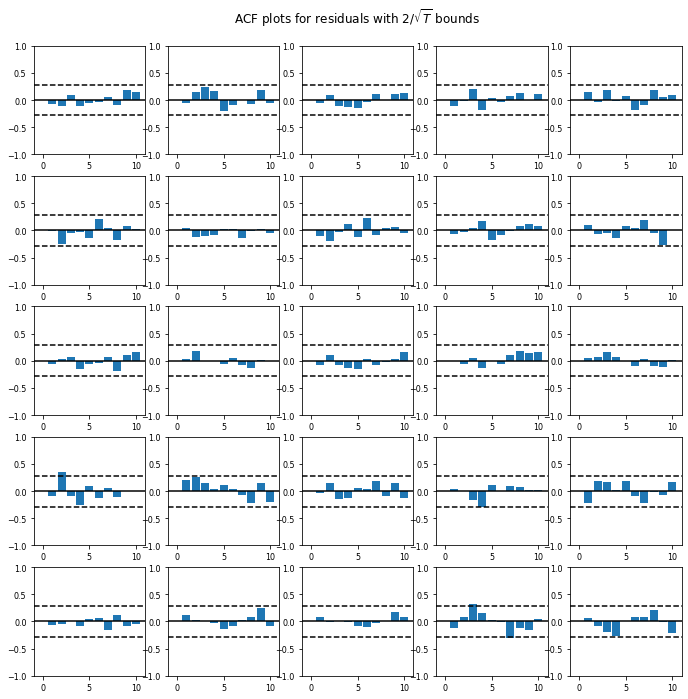

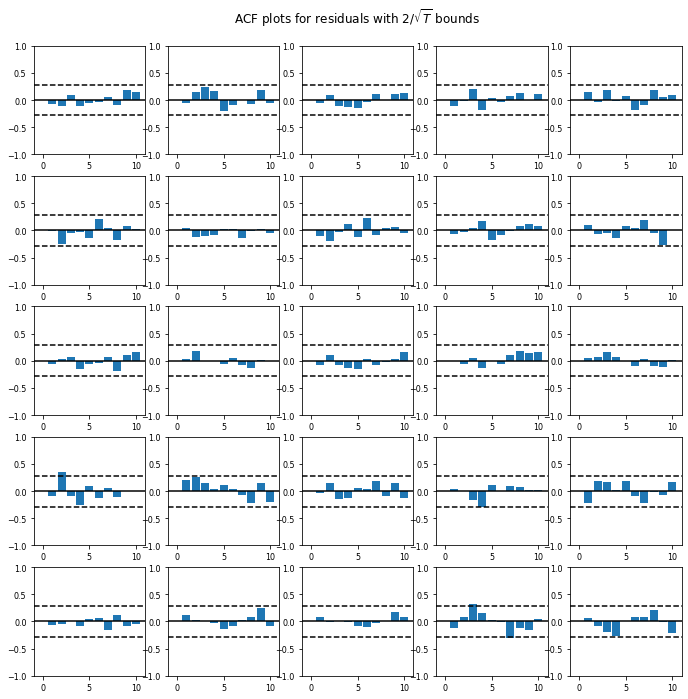

In [392]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
model_fit.plot_acorr()

#if residuals out of range -> unstable model 

In [393]:
######### GRANGER CAUSALITY TEST #########
#for gas price
GrangerCausality = model_fit.test_causality('price_gas', ['price_brent'], kind='f')
print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

Granger causality F-test. H_0: price_brent does not Granger-cause price_gas. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         2.185          2.143   0.046 (7, 70)
---------------------------------------------


FEVD for gas_gen
       gas_gen  price_gas  price_brent  open_interest_gas       ets
0     1.000000   0.000000     0.000000           0.000000  0.000000
1     0.920625   0.010519     0.000606           0.000486  0.067764
2     0.820163   0.104449     0.028134           0.001098  0.046155
3     0.696051   0.211626     0.023888           0.022243  0.046191
4     0.664919   0.223715     0.036723           0.025804  0.048839
5     0.581970   0.200407     0.072274           0.039503  0.105846
6     0.561206   0.194691     0.092807           0.049115  0.102181
7     0.515766   0.211248     0.086546           0.092543  0.093897
8     0.507457   0.200462     0.085185           0.105983  0.100913
9     0.499314   0.191134     0.084743           0.129608  0.095201
10    0.505252   0.185694     0.084934           0.128178  0.095941
11    0.467512   0.185141     0.094753           0.163850  0.088744
12    0.474051   0.182349     0.092072           0.164147  0.087381
13    0.466414   0.187192     0

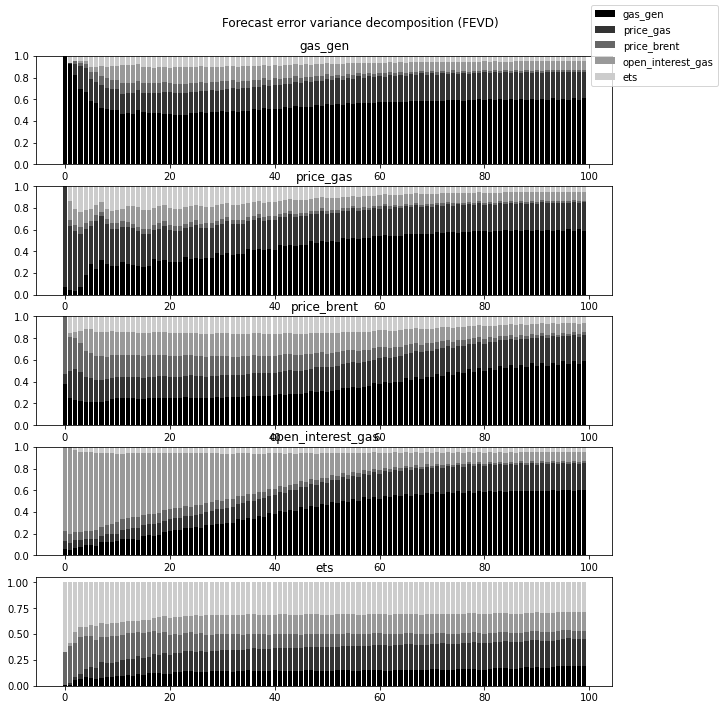

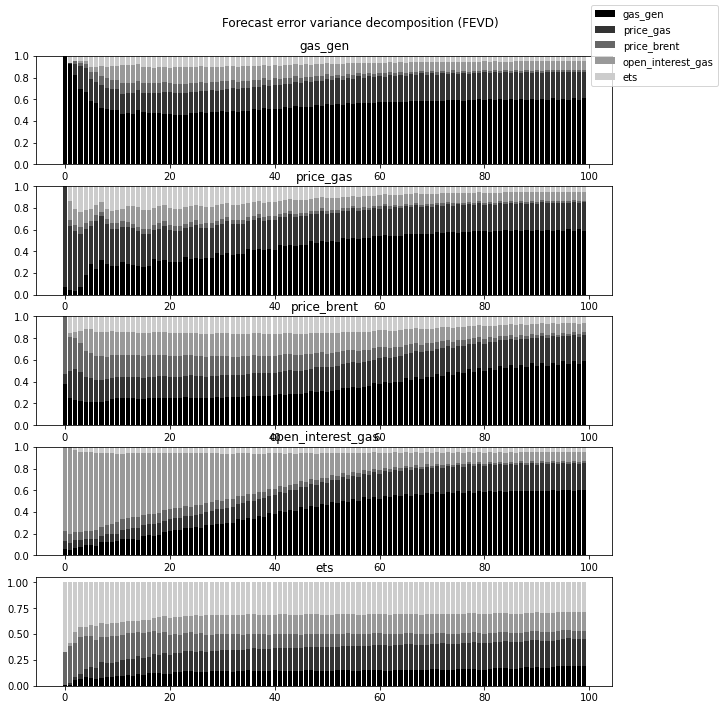

In [394]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 5 periods
fevd = model_fit.fevd(20)
fevd.summary()


#affichage pour n périodes
model_fit.fevd(100).plot()

IMPULSE RESPONSE ANALYSIS:

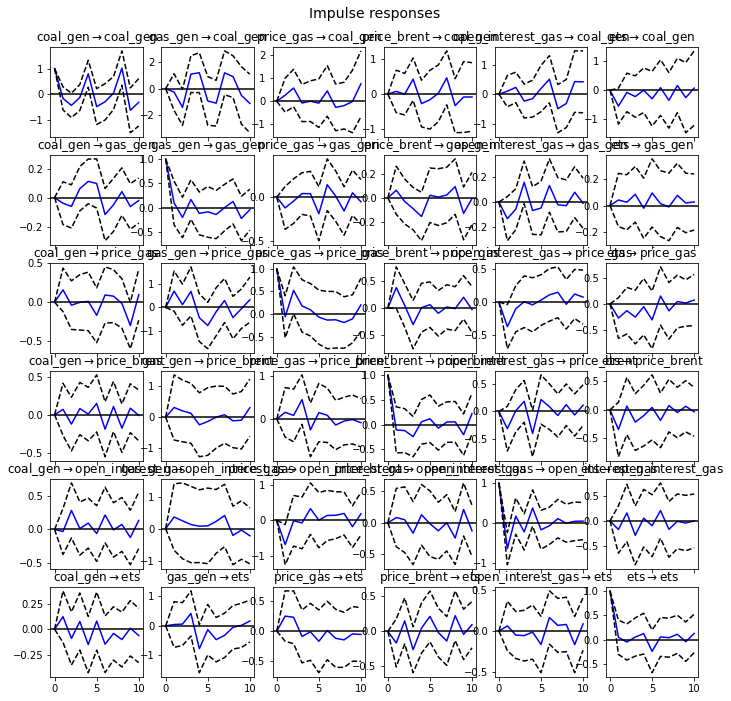

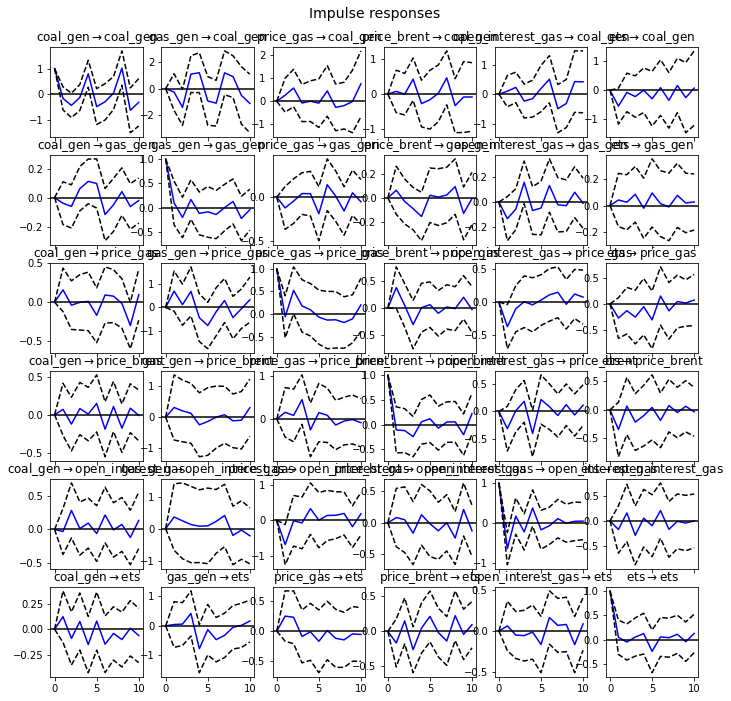

In [ ]:
irf = model_fit.irf(10)
irf.plot(orth=False)